In [1]:
# pip install pyodbc

In [2]:
import pyodbc

In [3]:
conn_str = "DRIVER={ODBC Driver 17 for SQL Server}; SERVER=127.0.0.1,1433; DATABASE=proj1;UID=sa;PWD=sqlPass12;"
conn = pyodbc.connect(conn_str)

cursor = conn.cursor()

In [4]:
with open("db_connection.txt", "w") as f:
    f.write(conn_str)

print("Database connection string saved.")

Database connection string saved.


In [5]:
cursor.execute("SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'")
tables = cursor.fetchall()

for table in tables:
    print(table[0])


sales
stores
inventory
products


In [6]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

In [7]:
def load_table(table_name):
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(query, conn)
    return df

sales_df = load_table("sales")
print(sales_df.head())

   Sale_ID        Date  Store_ID  Product_ID  Units
0        1  2017-01-01        24           4      1
1        2  2017-01-01        28           1      1
2        3  2017-01-01         6           8      1
3        4  2017-01-01        48           7      1
4        5  2017-01-01        44          18      1


In [8]:
stores_df = load_table("stores")
inventory_df = load_table("inventory")
products_df = load_table("products")

In [9]:
print("Missing Values in Sales Data:\n", sales_df.isnull().sum())
print("Missing Values in Stores Data:\n", stores_df.isnull().sum())
print("Missing Values in Inventory Data:\n", inventory_df.isnull().sum())
print("Missing Values in Products Data:\n", products_df.isnull().sum())

Missing Values in Sales Data:
 Sale_ID       0
Date          0
Store_ID      0
Product_ID    0
Units         0
dtype: int64
Missing Values in Stores Data:
 Store_ID           0
Store_Name         0
Store_City         0
Store_Location     0
Store_Open_Date    0
dtype: int64
Missing Values in Inventory Data:
 Store_ID         0
Product_ID       0
Stock_On_Hand    0
dtype: int64
Missing Values in Products Data:
 Product_ID          0
Product_Name        0
Product_Category    0
Product_Cost        0
Product_Price       0
dtype: int64


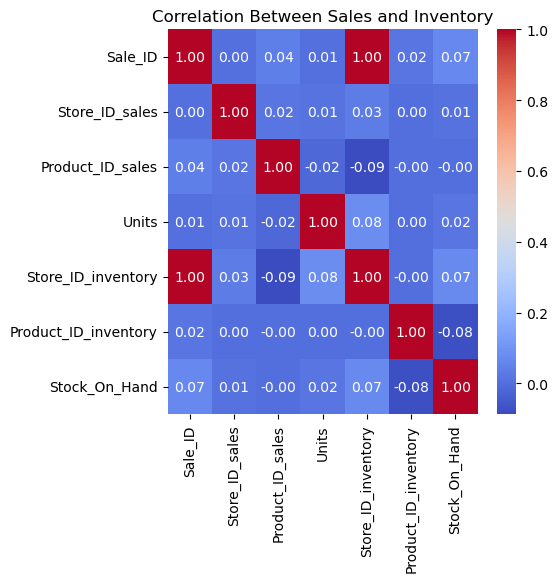

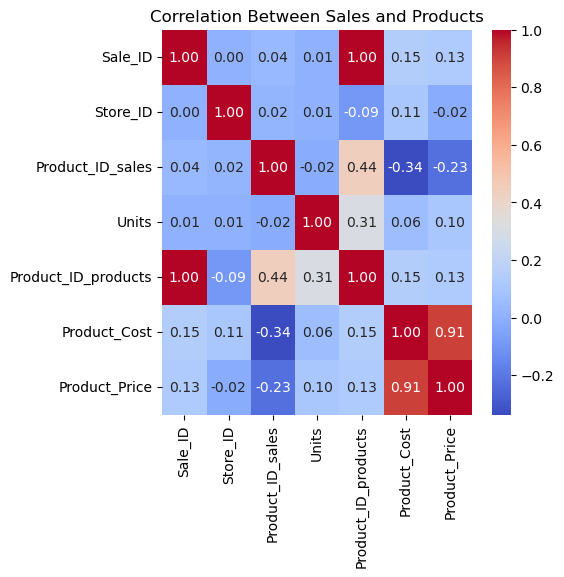

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sales_x_inventory = sales_df.join(
    inventory_df, lsuffix='_sales', rsuffix='_inventory').select_dtypes(include=['number'])

sales_x_products = sales_df.join(
    products_df, lsuffix='_sales', rsuffix='_products').select_dtypes(include=['number'])

corr_sales_inventory = sales_x_inventory.corr()
corr_sales_products = sales_x_products.corr()

plt.figure(figsize=(5, 5))
sns.heatmap(corr_sales_inventory, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Sales and Inventory")
plt.show()

plt.figure(figsize=(5, 5))
sns.heatmap(corr_sales_products, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Sales and Products")
plt.show()


In [11]:
sales_df.columns

Index(['Sale_ID', 'Date', 'Store_ID', 'Product_ID', 'Units'], dtype='object')

In [12]:
products_df.columns

Index(['Product_ID', 'Product_Name', 'Product_Category', 'Product_Cost',
       'Product_Price'],
      dtype='object')

In [13]:
merged_df = sales_df.merge(products_df, on='Product_ID', how='inner')
merged_df.columns

Index(['Sale_ID', 'Date', 'Store_ID', 'Product_ID', 'Units', 'Product_Name',
       'Product_Category', 'Product_Cost', 'Product_Price'],
      dtype='object')

In [14]:
merged_df = sales_df.merge(products_df, on='Product_ID', how='inner')
merged_df['Total_Amount'] = merged_df['Units'] * merged_df['Product_Price']

print(merged_df.head())

   Sale_ID        Date  Store_ID  Product_ID  Units      Product_Name  \
0        1  2017-01-01        24           4      1  Chutes & Ladders   
1       66  2017-01-01        24           4      1  Chutes & Ladders   
2       80  2017-01-01         7           4      1  Chutes & Ladders   
3       98  2017-01-01        24           4      1  Chutes & Ladders   
4      128  2017-01-01        24           4      1  Chutes & Ladders   

  Product_Category  Product_Cost  Product_Price  Total_Amount  
0            Games          9.99          12.99         12.99  
1            Games          9.99          12.99         12.99  
2            Games          9.99          12.99         12.99  
3            Games          9.99          12.99         12.99  
4            Games          9.99          12.99         12.99  


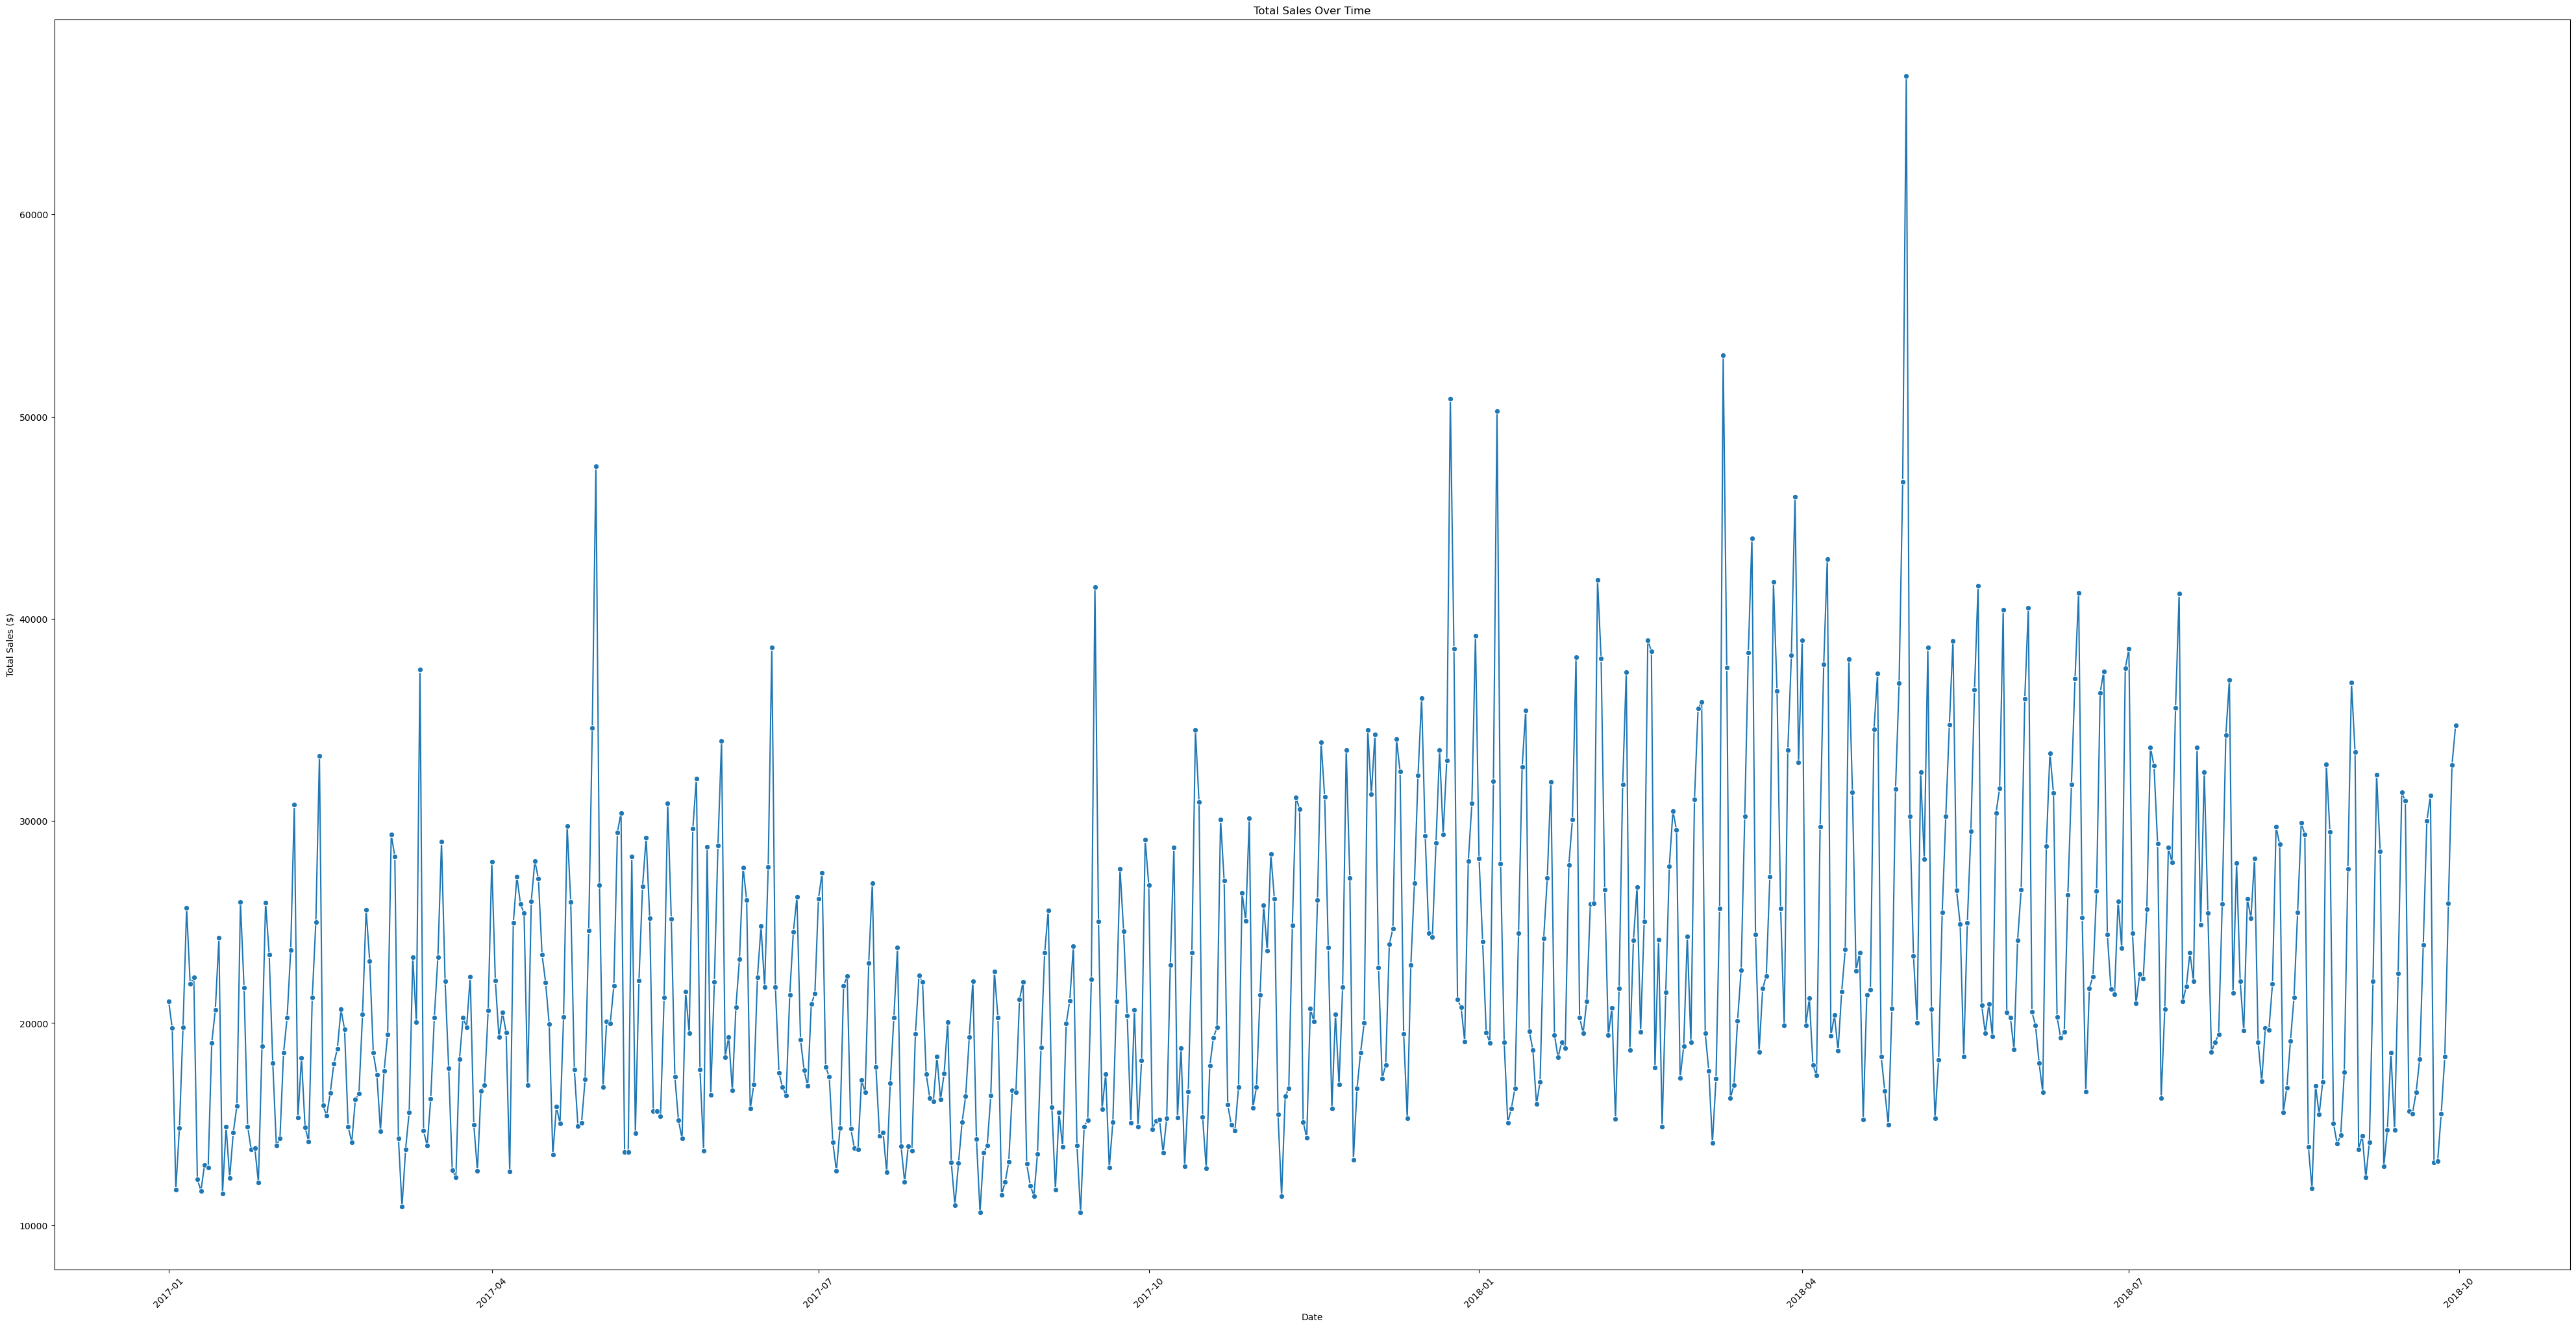

In [15]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')

sales_by_date = merged_df.groupby('Date')['Total_Amount'].sum().reset_index()

plt.figure(figsize=(50, 25))
sns.lineplot(data=sales_by_date, x='Date', y='Total_Amount', marker="o")
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales ($)")
plt.xticks(rotation=45)
plt.show()

In [16]:
merged_df['Quarter'] = merged_df['Date'].dt.to_period("Q").astype(str)
merged_df['Quarter'] = merged_df['Quarter'].replace({
    "2017Q1": "Q117", "2017Q2": "Q217", "2017Q3": "Q317", "2017Q4": "Q417",
    "2018Q1": "Q118", "2018Q2": "Q218", "2018Q3": "Q318"
})
print(merged_df[['Date', 'Quarter', 'Total_Amount']].head())

        Date Quarter  Total_Amount
0 2017-01-01    Q117         12.99
1 2017-01-01    Q117         12.99
2 2017-01-01    Q117         12.99
3 2017-01-01    Q117         12.99
4 2017-01-01    Q117         12.99


In [17]:
sales_by_quarter = merged_df.groupby('Quarter')['Total_Amount'].sum().reset_index()

In [18]:
quarter_order = ["Q117", "Q217", "Q317", "Q417", "Q118", "Q218", "Q318"]
sales_by_quarter = sales_by_quarter.set_index('Quarter').reindex(quarter_order).reset_index()

print(sales_by_quarter)

  Quarter  Total_Amount
0    Q117    1673391.75
1    Q217    2015423.10
2    Q317    1631301.00
3    Q417    2162382.23
4    Q118    2353344.05
5    Q218    2461309.81
6    Q318    2147420.41


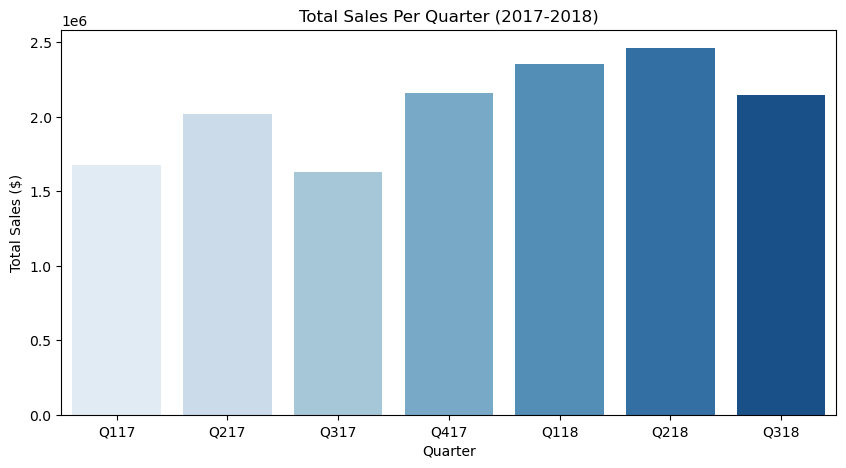

In [19]:
plt.figure(figsize=(10, 5))
sns.barplot(data=sales_by_quarter, x='Quarter', y='Total_Amount', palette="Blues")
plt.title("Total Sales Per Quarter (2017-2018)")
plt.xlabel("Quarter")
plt.ylabel("Total Sales ($)")
plt.show()

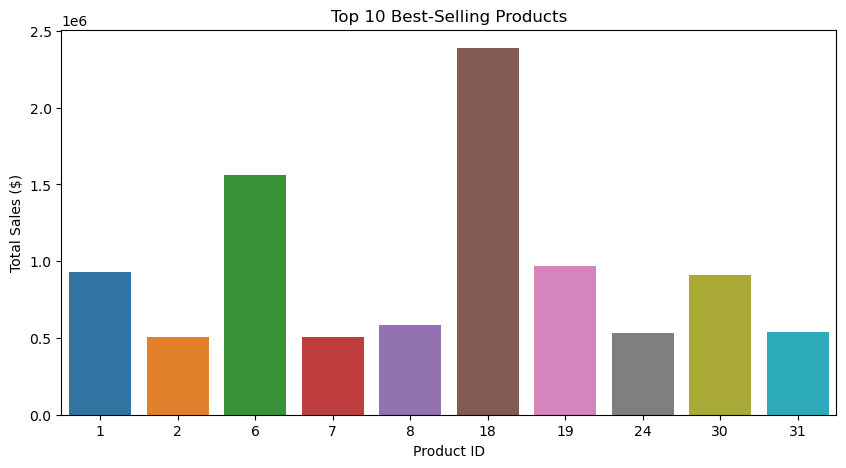

In [20]:
top_products = merged_df.groupby('Product_ID')['Total_Amount'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_products.index, y=top_products.values)
plt.title("Top 10 Best-Selling Products")
plt.xlabel("Product ID")
plt.ylabel("Total Sales ($)")
plt.show()

In [21]:
print(products_df[products_df['Product_ID'] == 18])

    Product_ID Product_Name Product_Category  Product_Cost  Product_Price
17          18  Lego Bricks             Toys         34.99          39.99


In [22]:
product_ids = [2, 7]
last_products = products_df[products_df['Product_ID'].isin(product_ids)]
print(last_products)

   Product_ID    Product_Name   Product_Category  Product_Cost  Product_Price
1           2  Animal Figures               Toys          9.99          12.99
6           7        Dart Gun  Sports & Outdoors         11.99          15.99


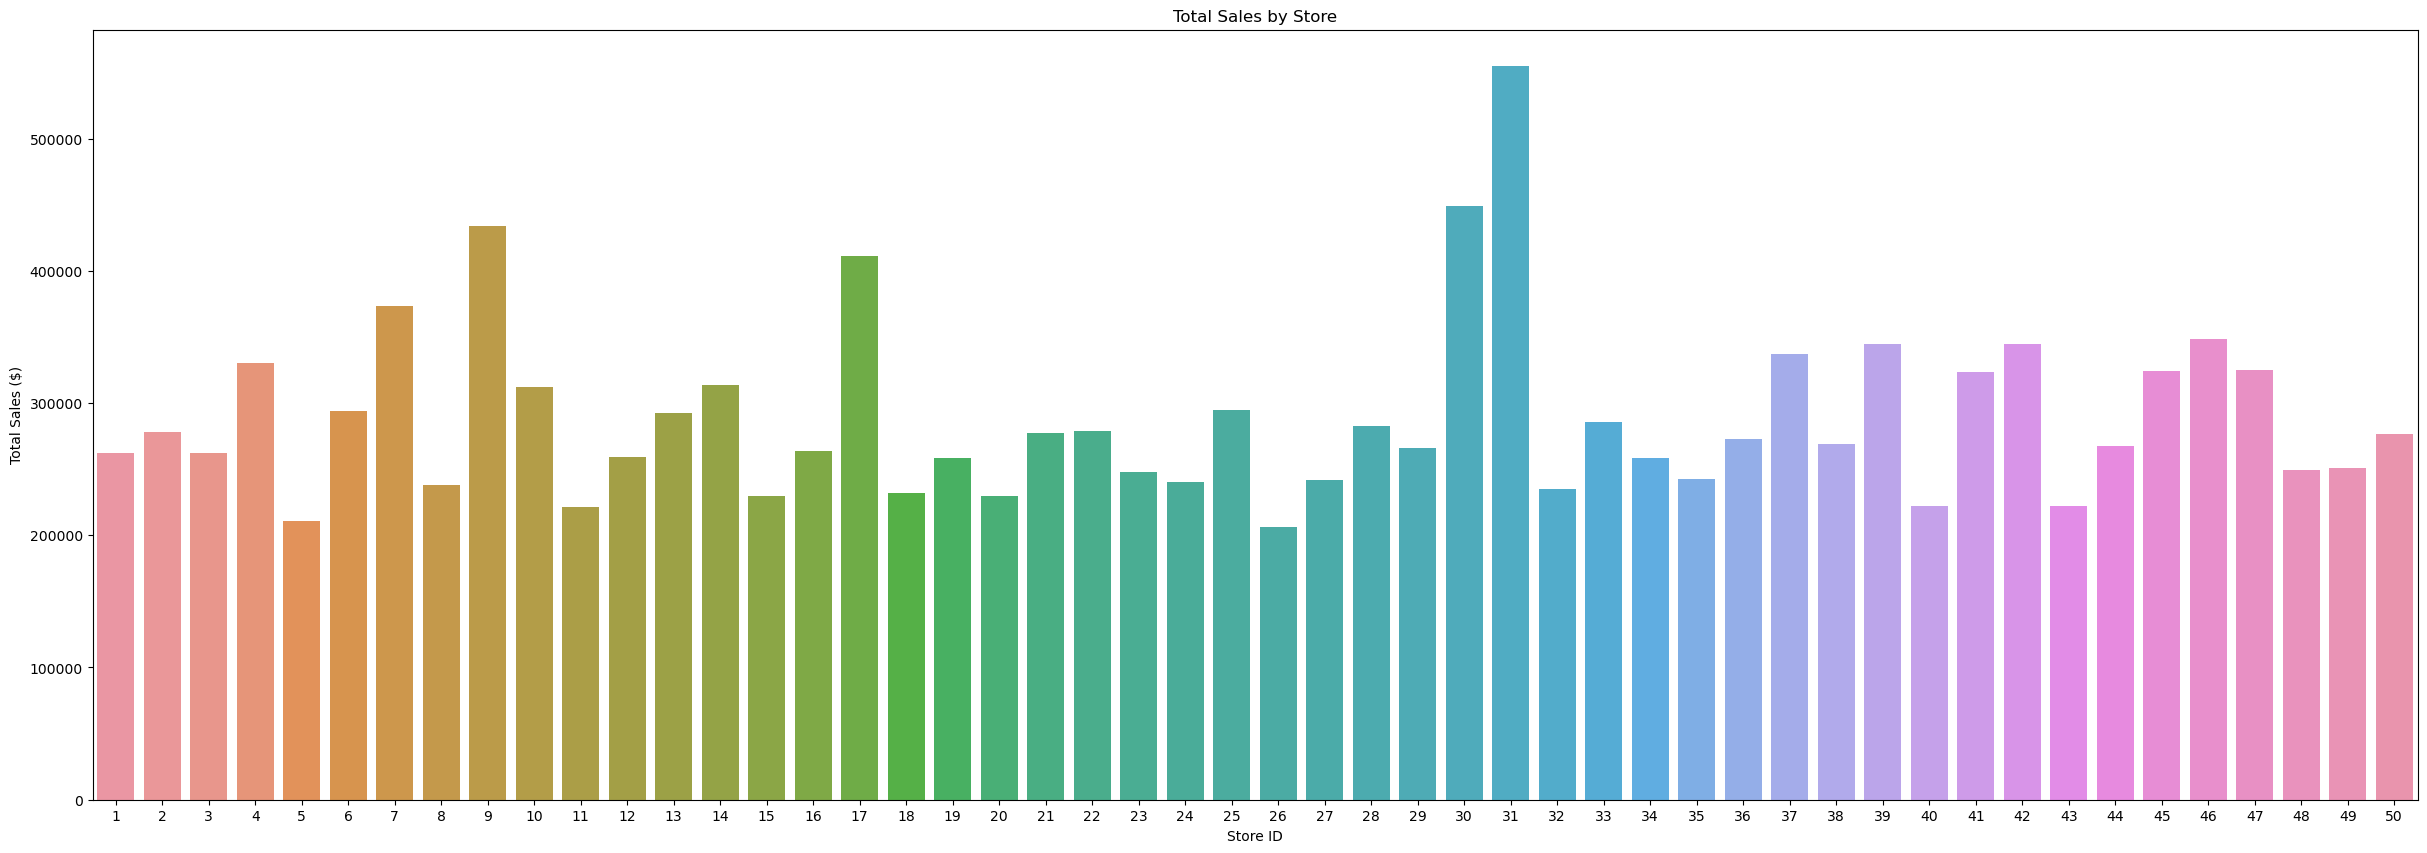

In [23]:
sales_by_store = merged_df.groupby('Store_ID')['Total_Amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(30, 10))
sns.barplot(x=sales_by_store.index, y=sales_by_store.values)
plt.title("Total Sales by Store")
plt.xlabel("Store ID")
plt.ylabel("Total Sales ($)")
plt.show()